In [115]:
# functions from John Slattery's work

import numpy as np


def linear_ramp(t, t0=0.0, dt=1.0, y0=0.0, dy=1.0, GS_slope = 0.0, GIS_slope=0.0):
    """Linear Ramp Function

    This function describes the piece-wise linear ramp.

    Parameter
    ---------
    t : np.ndarray
        Time variable
    t0 : float
        Start time of the ramp
    dt : float
        Transition length
    y0 : float
        Function value before the transition
    dy : float
        Hight of the transition
    GS_slope : float
        slope before transition - can be positive or negative
    GIS_slope : float
        slope after transition - can be positive or negative

    Return
    ------
    y : np.ndarray
        Function values of the linear transiton
    """
    lt_t0 = t < t0
    gt_t1 = t > t0 + dt
    condlist = [lt_t0,
                ~np.logical_or(lt_t0, gt_t1),
                gt_t1]
    funclist = [lambda t: y0 + GS_slope * (t - t0),
                lambda t: y0 + dy * (t - t0) / dt,
                lambda t: y0 + dy + GIS_slope * (t - t0 - dt)]
    y = np.piecewise(t, condlist, funclist)
    return y


def sample_ar1(n, alpha, sigma=1.0, x0=0):
    """Generate AR(1) noise for evenely sampled series"""
    x = np.zeros(n)
    x[0] = x0 + sigma * np.random.randn()
    sigma_e = np.sqrt(sigma ** 2 * (1 - alpha ** 2))
    for i in range(1, n):
        x[i] = alpha * x[i - 1] + sigma_e * np.random.randn()
    return x





import numpy as np
import pandas as pd

def gen_bi_directional_data(length, delta=10.0, lag=10, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=1.0, beta=1e-4, sigma=0.05):
    """
    Generate time series data demonstrating bi-directional causality.
    
    Args:
    length (int): Length of the time series data.
    delta (float): Time step.
    sigma (float): Standard deviation of the noise.
    alpha, beta, gamma, (float): Coefficients describing the interaction between the series.

    Returns:
    pandas.DataFrame: DataFrame containing bi-directionally linked synthetic data.

    """
    # let lag must be nagative integer
    if lag > 0:
        raise ValueError('Lag must be a negative integer.')

    # let beta to smaller than 1e-4
    if beta > 1e-4:
        raise ValueError('Beta must be smaller than 1e-4.')


    time = np.arange(length, step=delta, dtype='float')
    A = np.zeros(len(time))
    B = np.zeros(len(time))

    A[0] = np.random.normal(0, sigma)
    B[0] = np.random.normal(0, sigma)

    alpha = np.exp(-delta / tau)
    
    for t in range(1, len(time)+lag):
        A[t] = alpha * A[t-1] - beta * B[t+lag] + np.random.normal(0, sigma)
        B[t] = alpha * B[t-1] + beta * A[t+lag] + np.random.normal(0, sigma)

    
    trans_A = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)

    # trans_B = linear_ramp(time, t0=t0-lag*10, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)
    trans_B = trans_A


    A=trans_A+A
    B=trans_B+B
    
    df = pd.DataFrame({
        'time': time,
        'A': A,
        'B': B
    })
    
    # drop nan values
    df = df.dropna()

    return df


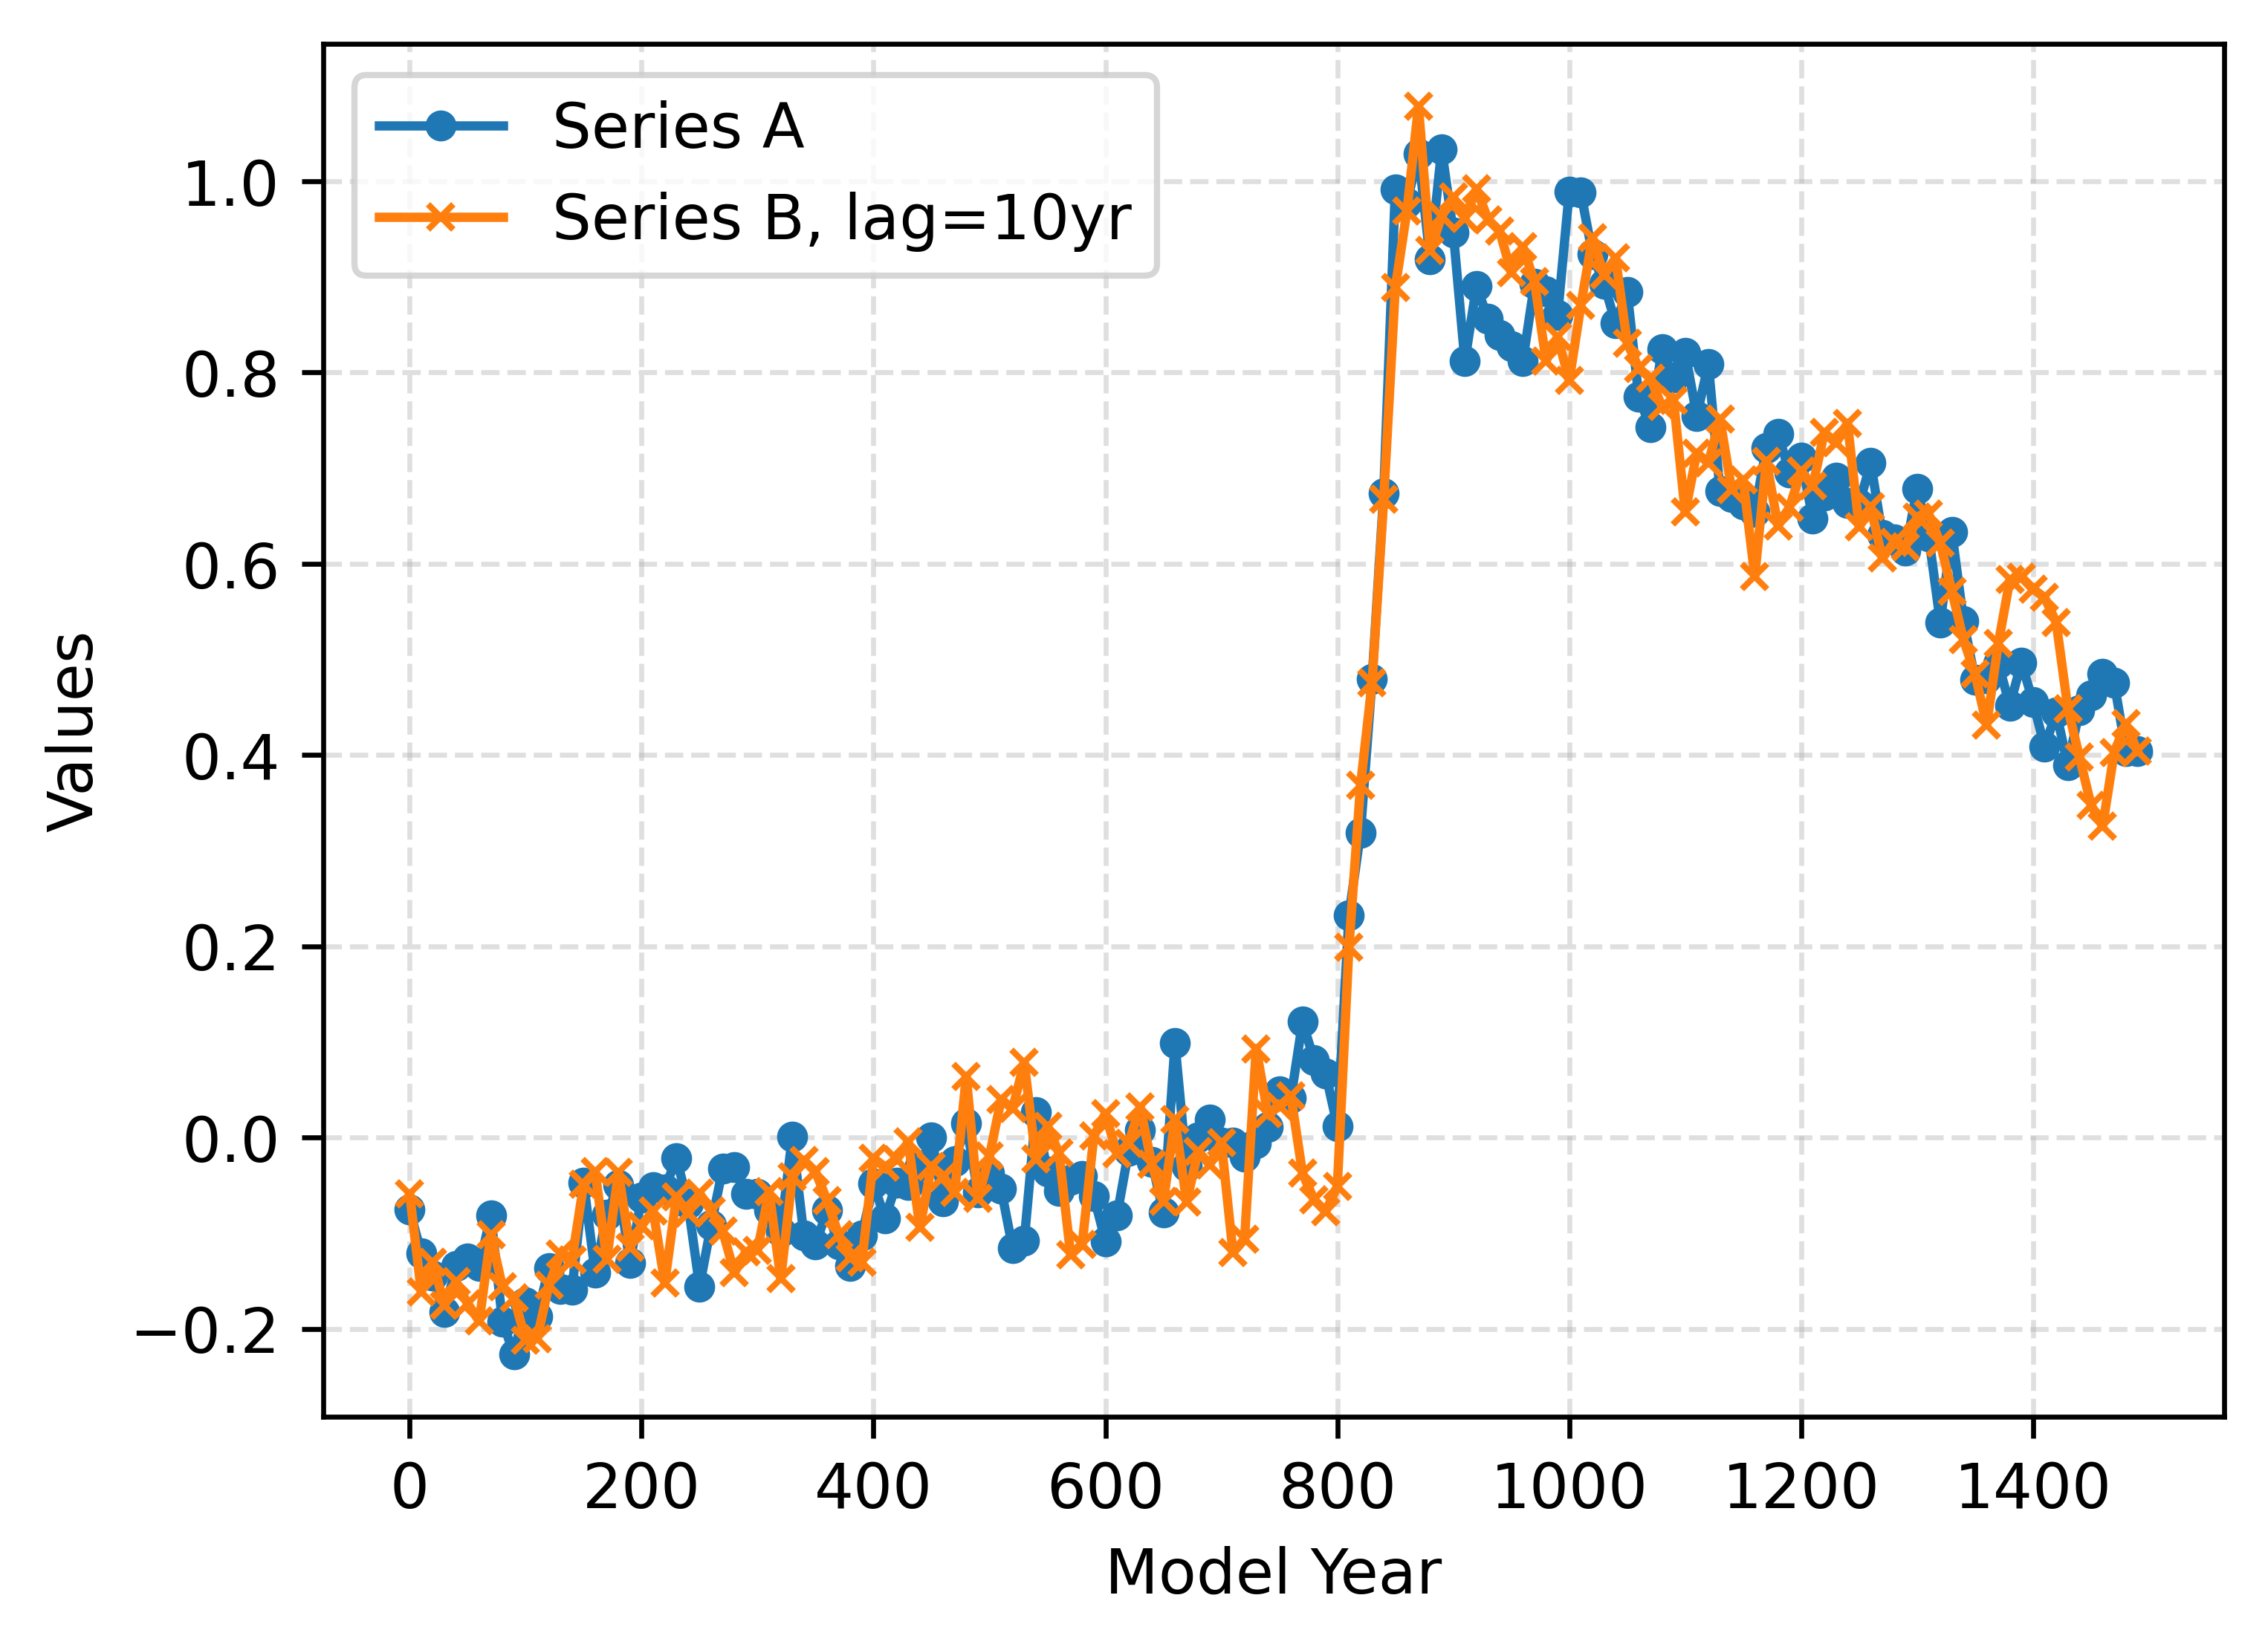

In [135]:
import matplotlib.pyplot as plt
# from toolbox import syth_ana_functions as saf
# import importlib
# importlib.reload(saf)

lag=-1
# data = gen_bi_directional_data(length=1500, delta=10, lag=lag, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=13.649751415738818, beta=0.3, sigma=0.05)
data = gen_bi_directional_data(length=1500, delta=10.0, lag=lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=5e-5, sigma=0.05)
# data = gen_bi_directional_data(length=1500, delta=10.0, lag=-3, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=0.3, gamma=0.3, sigma=0.05)


# Enhance the plot
plt.figure(figsize=(5.5, 4),dpi=600)  # Adjust the figure size
plt.plot(data['time'], data['A'], label='Series A', linestyle='-', marker='o', markersize=4)
plt.plot(data['time'], data['B'], label=f'Series B, lag={lag*-10}yr', linestyle='-', marker='x', markersize=4)

# Add grid, title, and labels
plt.grid(True, linestyle='--', alpha=0.4)
# plt.title('Time Series of Dummy Warming Data')
plt.xlabel('Model Year')
plt.ylabel('Values')

# Add legend
plt.legend()

plt.show()

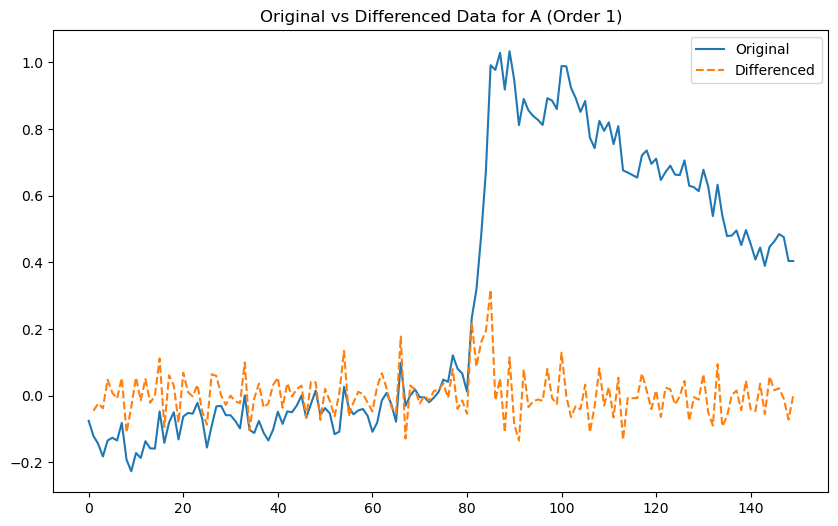

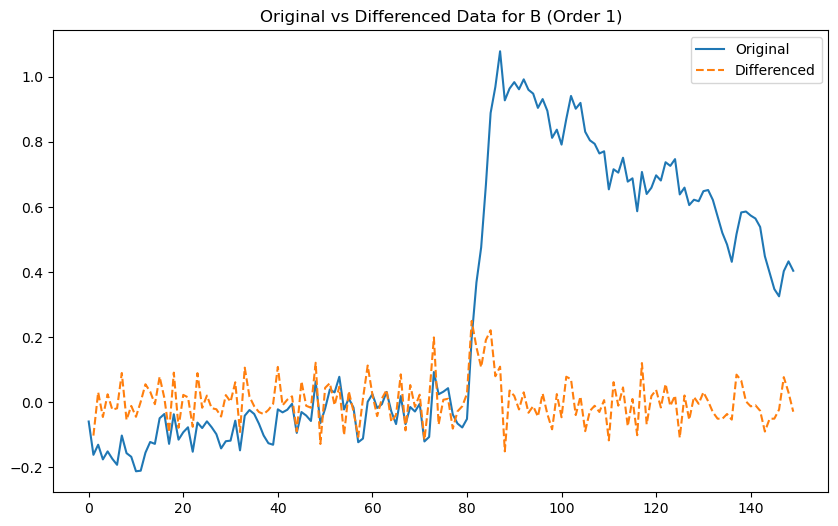

In [136]:
import importlib
from toolbox import GC_functions as GC
importlib.reload(GC)

df_AB_sta=GC.make_stationary(data,['A', 'B'], test_method='ADF',plot=True)

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: ylabel='A'>, <Axes: ylabel='B'>], dtype=object))

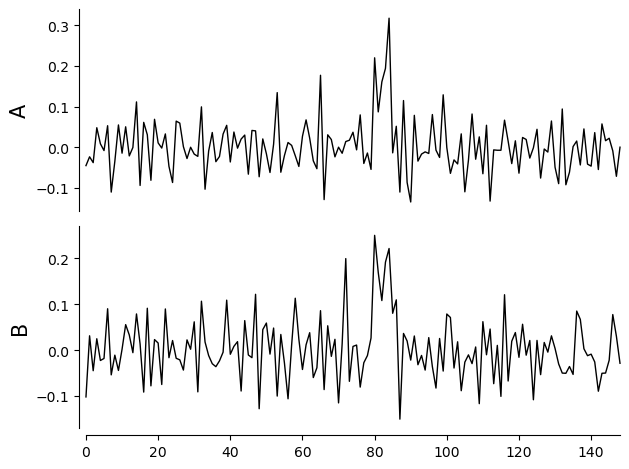

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn


# get the column of A and B from the dataframe and convert to numpy array
AB_array = df_AB_sta[['A', 'B']].values

var_names=['A', 'B']
# Create a Tigramite DataFrame object
dataframe_sta = pp.DataFrame(AB_array,
                         datatime=np.arange(len(AB_array)),
                         var_names=var_names)

tp.plot_timeseries(dataframe_sta,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable A has 1 link(s):
    [pc_alpha = 0.05]
        (B -2): max_pval = 0.00844, |min_val| =  0.218

    Variable B has 2 link(s):
    [pc_alpha = 0.05]
        (A -1): max_pval = 0.01349, |min_val| =  0.205
        (B -2): max_pval = 0.02395, |min_val| =  0.188

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable A has 2 link(s):
        (B  0): pval = 0.00000 | val =  0.413 | unoriented link
        (B -2): pval = 0.02126 | val =  0.192

    Variable B has 3 link(s):
        (A  0): pval = 0.00000 | val =  0.413 | unoriented link
        (B -2): pval = 0.01308 | val =  0.208
        (A 

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

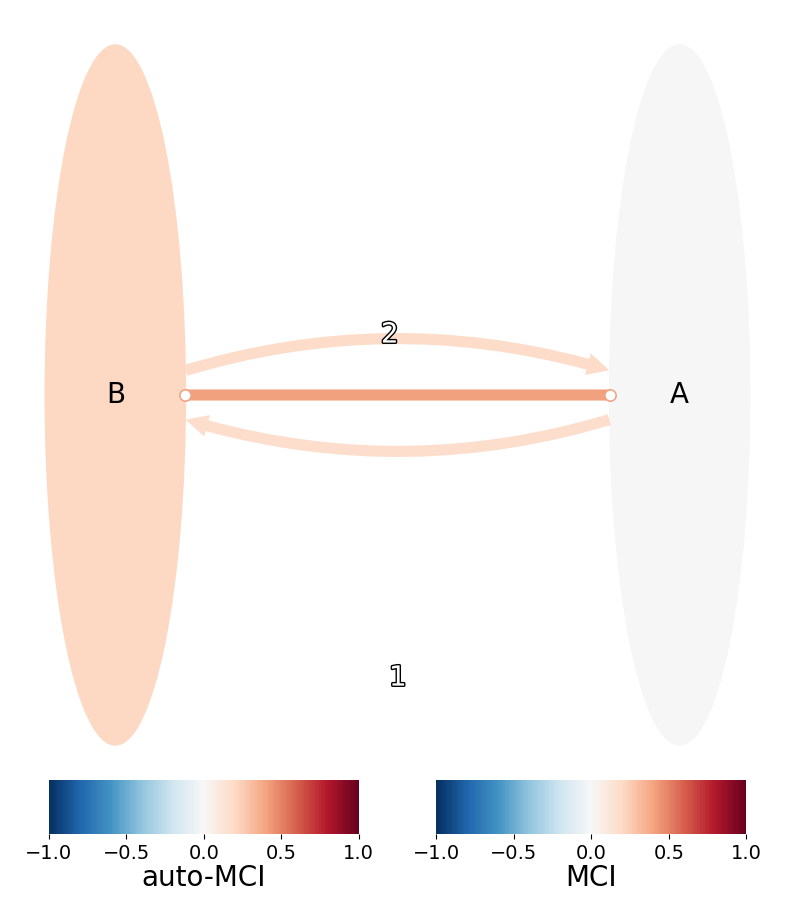

In [138]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_sta,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=20,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.5
    )

In [91]:
results

{'graph': array([[['', '', '-->'],
         ['o-o', '-->', '']],
 
        [['o-o', '-->', '-->'],
         ['', '', '-->']]], dtype='<U3'),
 'p_matrix': array([[[1.00000000e+00, 1.34051754e-01, 3.56785299e-02],
         [6.23493676e-04, 5.78297031e-03, 3.62670306e-01]],
 
        [[6.23493676e-04, 1.27918519e-02, 7.22137956e-04],
         [1.00000000e+00, 7.07666767e-01, 3.29341941e-02]]]),
 'val_matrix': array([[[ 0.        , -0.12725612, -0.1777084 ],
         [ 0.28466491,  0.2313186 ,  0.07723305]],
 
        [[ 0.28466491,  0.20845732,  0.28146106],
         [ 0.        ,  0.03174121, -0.17975563]]]),
 'conf_matrix': None}

In [98]:
results['p_matrix']

array([[[1.00000000e+00, 1.34051754e-01, 3.56785299e-02],
        [6.23493676e-04, 5.78297031e-03, 3.62670306e-01]],

       [[6.23493676e-04, 1.27918519e-02, 7.22137956e-04],
        [1.00000000e+00, 7.07666767e-01, 3.29341941e-02]]])

(<Figure size 650x650 with 1 Axes>, <Axes: >)

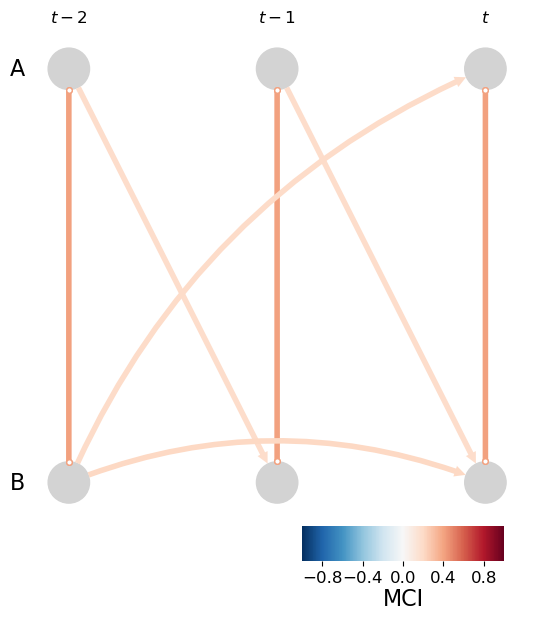

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 6.5), dpi=100)

tp.plot_time_series_graph(
    fig_ax=(fig, ax),
    val_matrix=results['val_matrix'],
    graph = results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    label_fontsize=16,
    tick_label_size=12
)

In [85]:
results

{'graph': array([[['', '', '-->'],
         ['o-o', '-->', '']],
 
        [['o-o', '-->', '-->'],
         ['', '', '-->']]], dtype='<U3'),
 'p_matrix': array([[[1.00000000e+00, 1.34051754e-01, 3.56785299e-02],
         [6.23493676e-04, 5.78297031e-03, 3.62670306e-01]],
 
        [[6.23493676e-04, 1.27918519e-02, 7.22137956e-04],
         [1.00000000e+00, 7.07666767e-01, 3.29341941e-02]]]),
 'val_matrix': array([[[ 0.        , -0.12725612, -0.1777084 ],
         [ 0.28466491,  0.2313186 ,  0.07723305]],
 
        [[ 0.28466491,  0.20845732,  0.28146106],
         [ 0.        ,  0.03174121, -0.17975563]]]),
 'conf_matrix': None}

In [ ]:
# save the results to D:\VScode\Paleoclimate_causality\syth_test_results
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_results_twoways_GC.npy', causal_AB_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_results_twoways_GC.npy', causal_BA_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_results_red_nozscore_twoways_GC.npy', causal_results_red_nozscore)

In [96]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc
from tigramite.models import LinearMediation, Prediction

In [97]:
np.random.seed(42)
# links_coeffs = {0: [],
#                 1: [((0, -1), 0.5)],
#                 2: [((1, -1), 0.5)],
#                 }
links_coeffs = {0: [((0,-1), 0.8)],
                1: [((1,-1), 0.8), ((0, -1), 0.5)],
                2: [((2,-1), 0.8), ((1, -1), 0.5)],
                }
var_names = [r"$X$", r"$Y$", r"$Z$"]
    
data, true_parents = pp.var_process(links_coeffs, T=1000)

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         var_names=var_names)
med = LinearMediation(dataframe=dataframe)
med.fit_model(all_parents=true_parents, tau_max=4)

data generating models are now in toymodels folder: from tigramite.toymodels import structural_causal_processes as toys.


TypeError: cannot unpack non-iterable NoneType object